In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
import os

#Parameters
input_size = 784
hidden_size = 400
latent_size = 20



# Define the VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        #return mu + std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, input_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing
batch_size = 512

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10

# Load the model
file_name = "vae_mnist_v2_1.pth"
load_pretrained = True

if load_pretrained:
    if os.path.exists(file_name):
        model.load_state_dict(torch.load(file_name))
        print("Loaded pretrained model.")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# Save the model
torch.save(model.state_dict(), file_name)


Loaded pretrained model.
Epoch 1/10, Loss: 28.1309
Epoch 2/10, Loss: 28.1243
Epoch 3/10, Loss: 28.1050
Epoch 4/10, Loss: 28.0911
Epoch 5/10, Loss: 28.1058
Epoch 6/10, Loss: 28.0838
Epoch 7/10, Loss: 28.0545
Epoch 8/10, Loss: 28.0767
Epoch 9/10, Loss: 28.0858
Epoch 10/10, Loss: 28.0608


Models :
v2.0 :
v2.1 :
 

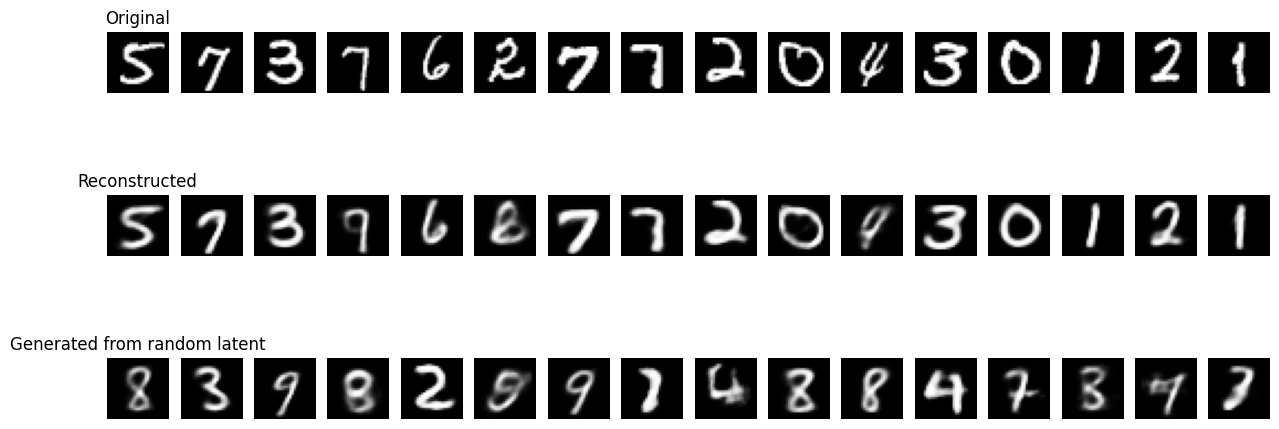

In [3]:
import matplotlib.pyplot as plt

# Function to visualize original, reconstructed, and generated samples
def visualize_results(model, data_loader, num_samples=16):
    model.eval()
    
    # Get a batch of real data
    data, _ = next(iter(data_loader))
    data = data[:num_samples]

    # Reconstruct data
    with torch.no_grad():
        recon, _, _ = model(data.to(device))

    # Generate from random latent vectors
    z = torch.randn(num_samples, latent_size).to(device)
    generated_samples = model.decode(z)

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

    for ax, img, recon_img, gen_img in zip(axes.T, data, recon, generated_samples):
        ax[0].imshow(img[0].cpu().numpy(), cmap='gray')
        ax[1].imshow(recon_img.view(28, 28).cpu().numpy(), cmap='gray')
        ax[2].imshow(gen_img.view(28, 28).detach().cpu().numpy(), cmap='gray')

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    axes[2, 0].set_title('Generated from random latent')

    plt.show()

visualize_results(model, train_loader)


In [4]:
import torch
from torchviz import make_dot

# ... [your VAE model definition and loss function here] ...

# Dummy input data
x = torch.randn((batch_size, input_size))

# Model and optimizer
model = VAE()
optimizer = torch.optim.Adam(model.parameters())

# Forward pass
recon_x, mu, logvar = model(x)
loss = vae_loss(recon_x, x, mu, logvar)

# Visualize the computation graph
dot = make_dot(loss, params=dict(model.named_parameters()))
dot.view()  # This will generate and display a .pdf file showing the computation graph


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [4]:
# To store latent values and labels
latent_values = []
labels = []

with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, input_size))
        latent_values.append(mu.cpu())
        labels.append(label)

latent_values = torch.cat(latent_values, dim=0)
labels = torch.cat(labels, dim=0)


In [5]:
from sklearn.manifold import TSNE

latent_values_2D = TSNE(n_components=2).fit_transform(latent_values)


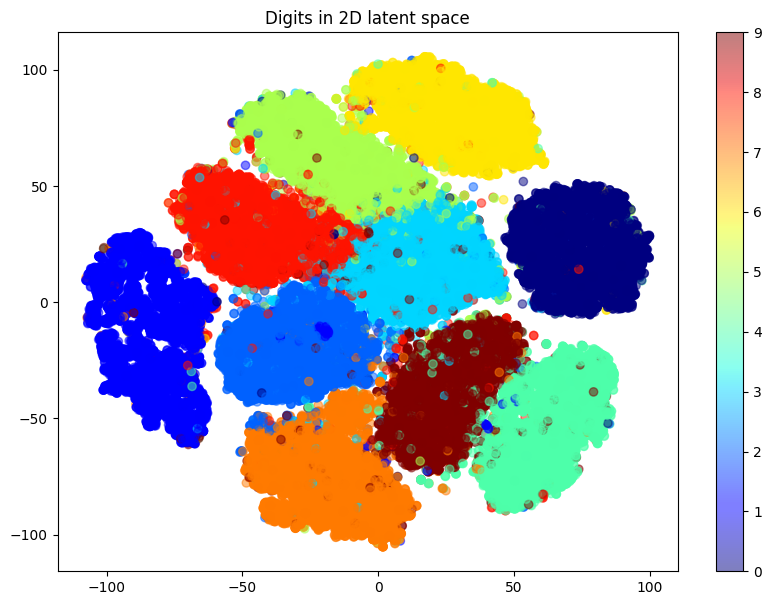

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_values_2D[:, 0], latent_values_2D[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.colorbar(scatter)
plt.title("Digits in 2D latent space")
plt.show()


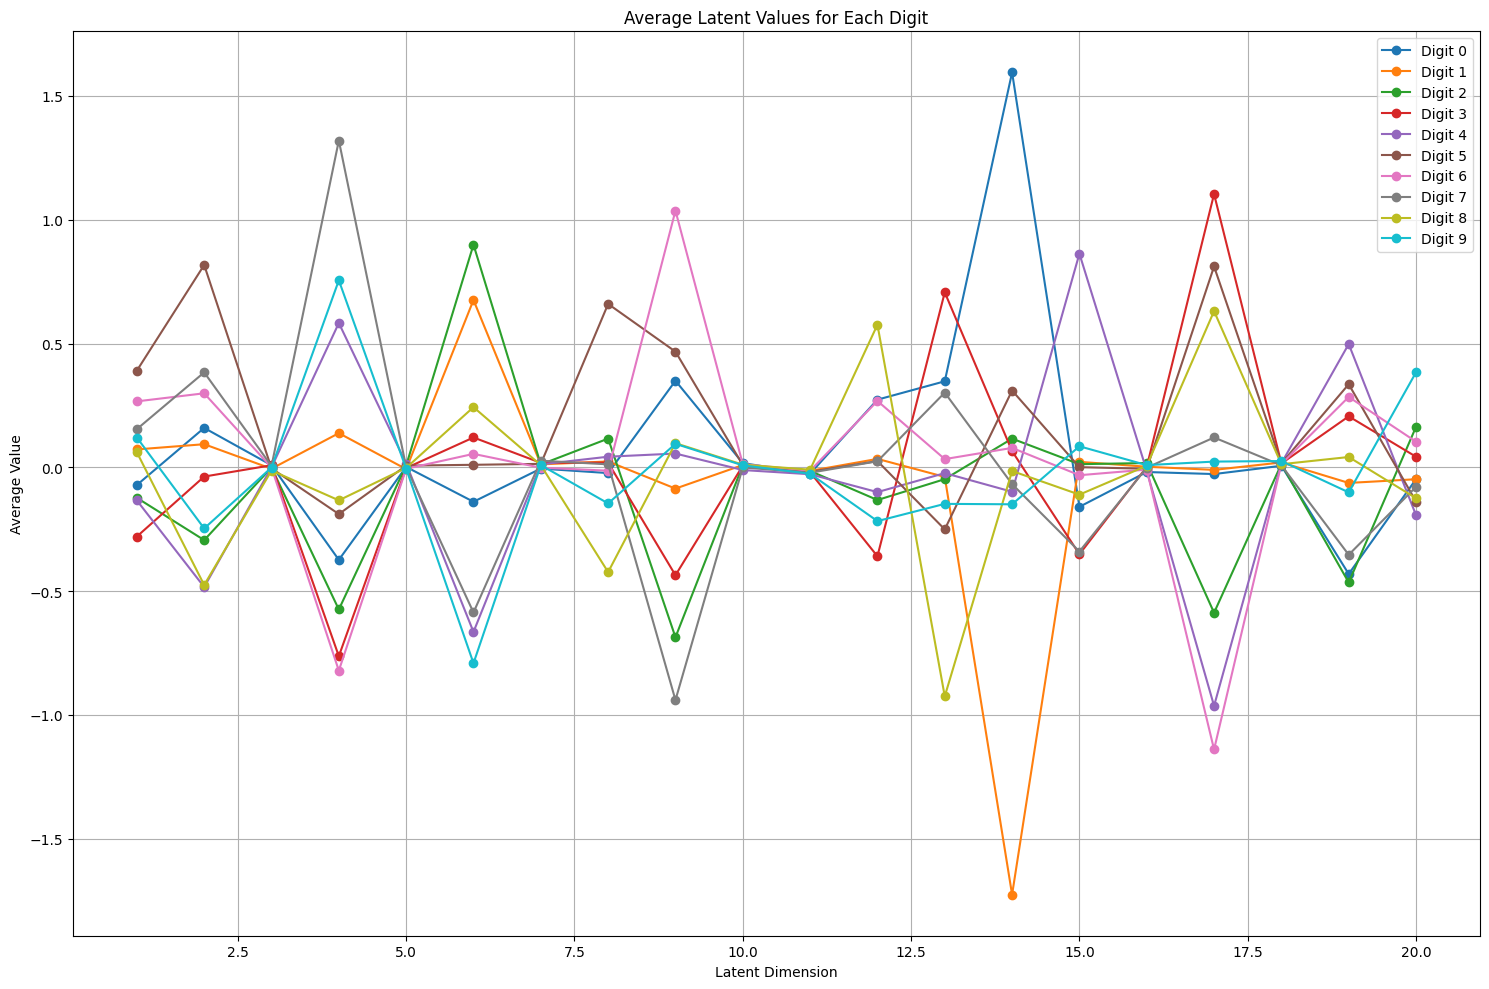

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store average latent values for each digit
average_latents = {i: [] for i in range(10)}
for i in range(10):  # for each digit
    mask = labels == i
    avg_latent = latent_values[mask].mean(dim=0)
    average_latents[i] = avg_latent.tolist()

# Set up the figure and axis
plt.figure(figsize=(15, 10))

# Define an array for the x-axis (represents the 20 dimensions of the latent space)
x = np.arange(1, 21)

# Plot each digit's average latent values
for digit, avg_latent in average_latents.items():
    plt.plot(x, avg_latent, label=f"Digit {digit}", marker='o')

# Add labels, title, and legend
plt.xlabel('Latent Dimension')
plt.ylabel('Average Value')
plt.title('Average Latent Values for Each Digit')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


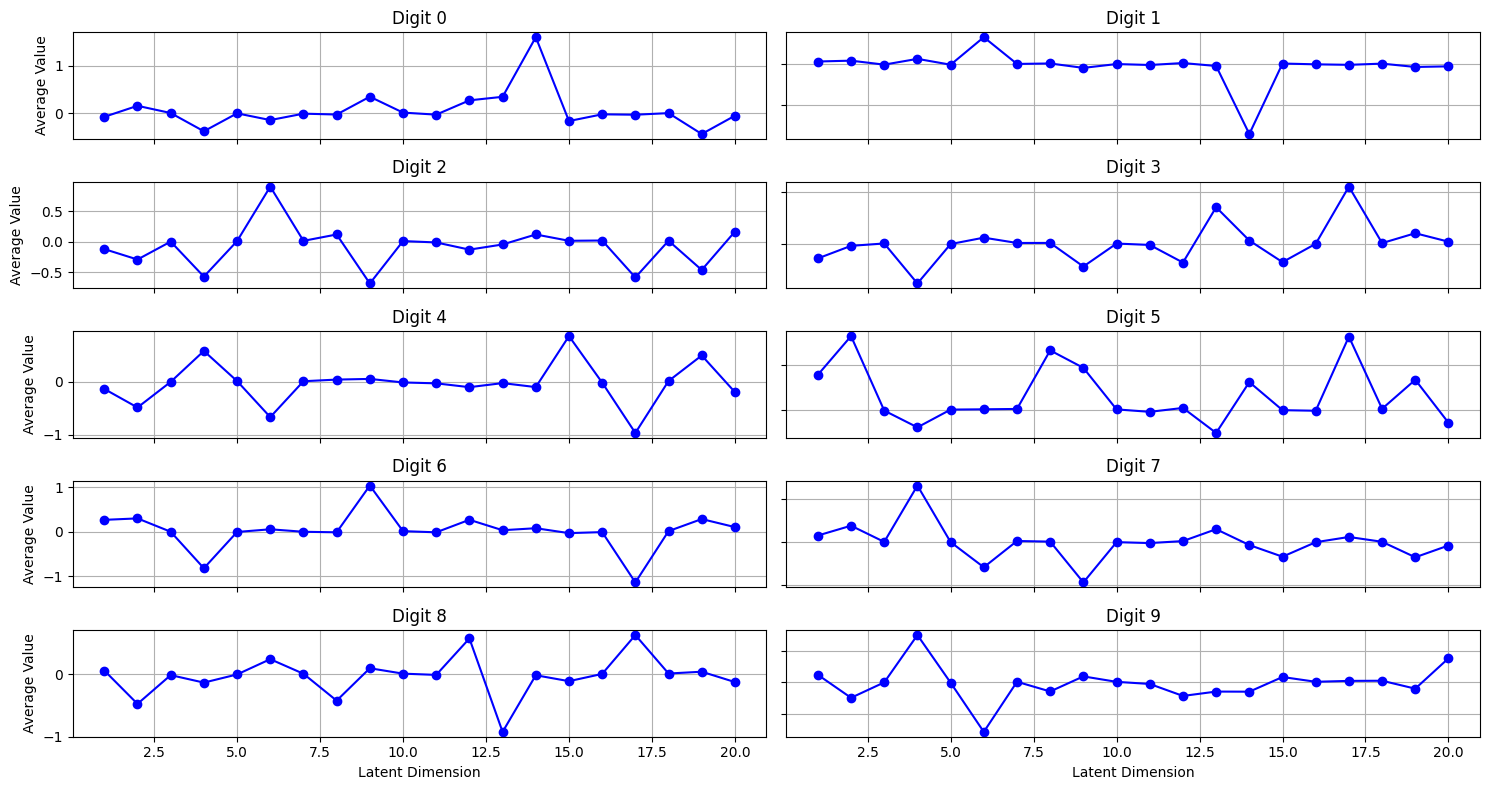

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes for 10 subplots (2 rows x 5 columns)
fig, axes = plt.subplots(5, 2, figsize=(15, 8))

# Define an array for the x-axis (represents the 20 dimensions of the latent space)
x = np.arange(1, 21)

# Plot each digit's average latent values on a separate subplot
for idx, (digit, avg_latent) in enumerate(average_latents.items()):
    ax = axes[idx // 2,idx % 2]  # Determine the row and column of the subplot
    ax.plot(x, avg_latent, label=f"Digit {digit}", marker='o', color='blue')
    ax.set_title(f"Digit {digit}")
    ax.grid(True)

# Add labels to the bottom and leftmost subplots
for ax in axes.flat:
    ax.set(xlabel='Latent Dimension', ylabel='Average Value')
    ax.label_outer()  # This will hide x labels for top plots and y labels for right plots to avoid redundancy

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [24]:
import ipywidgets as widgets
from IPython.display import display, clear_output
model.eval()
# Define a function that takes 20 arguments (one for each slider/latent dimension)
def visualize_latent(z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20):
    z = torch.tensor([z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20]).float().to(device)
    with torch.no_grad():
        decoded_img = model.decode(z).view(28, 28).cpu().numpy()  # Assuming your images are 28x28
    
    # Display the output image
    clear_output(wait=True)
    plt.imshow(decoded_img, cmap='gray')
    plt.axis('off')
    plt.show()

# Create the sliders
sliders = {
    f'z{i+1}': widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description=f'z{i+1}') 
    for i in range(20)
}
def reset_sliders(button):
    for slider in sliders.values():
        slider.value = 0

reset_button = widgets.Button(description="Reset Sliders")
reset_button.on_click(reset_sliders)

# Define the layout for the GridBox
grid_layout = widgets.Layout(
    width='100%',
    grid_template_columns='repeat(4, 1fr)',  # 4 columns with equal width
    grid_template_rows='repeat(5, auto)',    # 5 rows (because 20 sliders / 4 columns)
    grid_gap='10px'                           # spacing between sliders
)

# Create the GridBox with sliders
grid = widgets.GridBox(list(sliders.values()), layout=grid_layout)
ui = widgets.VBox([grid, reset_button])
out = widgets.interactive_output(visualize_latent, sliders)
display(ui, out)



Output()